# Welcome to Store Sales Forcasting (Time Series)  

This data analysis investigates the sale prices of various products across different stores within Corporacion Favorita, employing diverse metrics such as promotional status, holidays, oil prices, specific store locations, and product types. The objective is twofold: first, to discern patterns influencing product pricing, and second, to optimize inventory management by ensuring that popular products are adequately stocked while preventing overstocking of less popular items. The study will be executed by a data scientist, utilizing advanced analytical methods to derive actionable insights for strategic decision-making within the retail context.

# OBJECTIVES:

.To scrutinize diverse factors influencing sales across different stores.

. To construct a model that enhances the precision of predicting unit sales for a multitude of items across various Favorita stores.

.The evaluation metric for this case study is the Root Mean Squared Logarithmic Error.

Note :- Data preprocessing is Replicated from an pre-exist Kaggle NoteBook

In [15]:
#Import 
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [16]:
#Import Data 
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
holidays = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")
stores = pd.read_csv("stores.csv")

In [17]:
print(test_data.shape)
#print(train_data.shape)

(28512, 5)


#Overview of data features

Stores

store_nbr — the number of a store

city — city to which the store belongs to

state — state to where store is located

type — type of store

cluster — cluster is a grouping of similar stores

Train data
id — item id

date — date on record

store_nbr — store number

family — family of product

sales — number of sales

onpromotion — gives the total number of items in a product family that were promoted at a store at a given date

Holidays
date — date of the holiday

type — type of the holiday

locale — whether it’s a Local or Regional holiday

local_name — name of the city

description — description of the holiday

transfered — whether the holiday is transfered to another date or not

Oil
date — date

dcoilwtico — oil price for the given date

data contains dates from march 2012 to december 2017

In [18]:
import calendar

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [19]:
train_data['Year'] = train_data['date'].apply(lambda time: time.year)
test_data['Year'] = test_data['date'].apply(lambda time: time.year)

### Finding the missing Dates

In [20]:
train_data_start = train_data['date'].min()
train_data_end = train_data['date'].max()

date_range = pd.date_range(start=train_data_start, end=train_data_end)
dates_missing = date_range.difference(train_data['date'])

print("Missing dates:")
print(dates_missing)

Missing dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [21]:
#filling the missing date with zeroes
multi_index = pd.MultiIndex.from_product([pd.date_range(train_data_start, train_data_end),train_data.store_nbr.unique(),train_data.family.unique()],names=['date','store_nbr','family'],)
train_data = train_data.set_index(['date','store_nbr','family']).reindex(multi_index).reset_index()
train_data[['sales','onpromotion']] = train_data[['sales','onpromotion']].fillna(0.)
train_data.id = train_data.id.interpolate(method="linear")

In [22]:
#repeating it to the test data
test_data_start = test_data['date'].min()
test_data_end = test_data['date'].max()

missing_dates = pd.date_range(test_data_start, test_data_end).difference(test_data['date'].unique())
missing_dates_test = missing_dates.strftime("%Y-%m-%d").tolist()
print("Missing dates:")
print(missing_dates_test)

#additional columns for future seperation
test_data['test'] = 1
train_data['test'] = 0

Missing dates:
[]


### Calculating Oil price

In [34]:
fig = px.line(oil, x='date', y="dcoilwtico", hover_name='dcoilwtico', width=600, height=400)

fig.update_layout(plot_bgcolor='lightgrey',
    font_family="Courier New",font_color="red",
    title_font_family="Times New Roman", title_font_color="darkgrey", 
title=dict(text='Crude oil price/barrel</sup>', font=dict(size=30)),
hoverlabel=dict( bgcolor="black", font_size=15, font_family="Times New Roman"))

In [24]:
# Create a date range from the start of training data to the end of test data
date_range = pd.date_range(train_data_start, test_data_end)

# Create a DataFrame with the date range
date_df = pd.DataFrame({'date': date_range})

# Merge the date_df with oil data using an outer join
oil = pd.concat([date_df,oil.drop('date',axis=1)],axis = 1)

# Sort the DataFrame by date and reset the index
oil = oil.sort_values('date', ignore_index=True)


# fill missing values using linear interpolation
oil.dcoilwtico = oil.dcoilwtico.interpolate(method="linear", limit_direction="both")

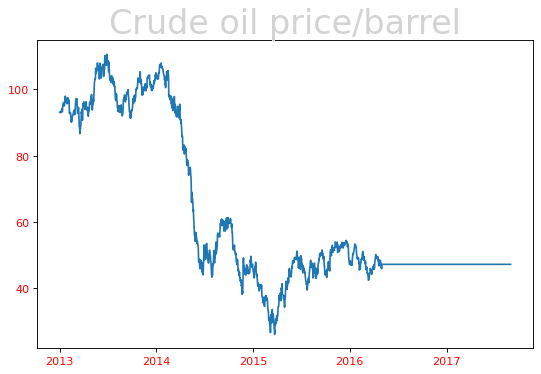

In [25]:
plt.figure(figsize=(8,5), dpi= 80)
plt.plot('date', 'dcoilwtico', data=oil, color='tab:blue')
plt.title('Crude oil price/barrel', fontsize=30, color ='lightgrey' )
plt.xticks(color='red')
plt.yticks(color='red')
plt.show()

### Holidays

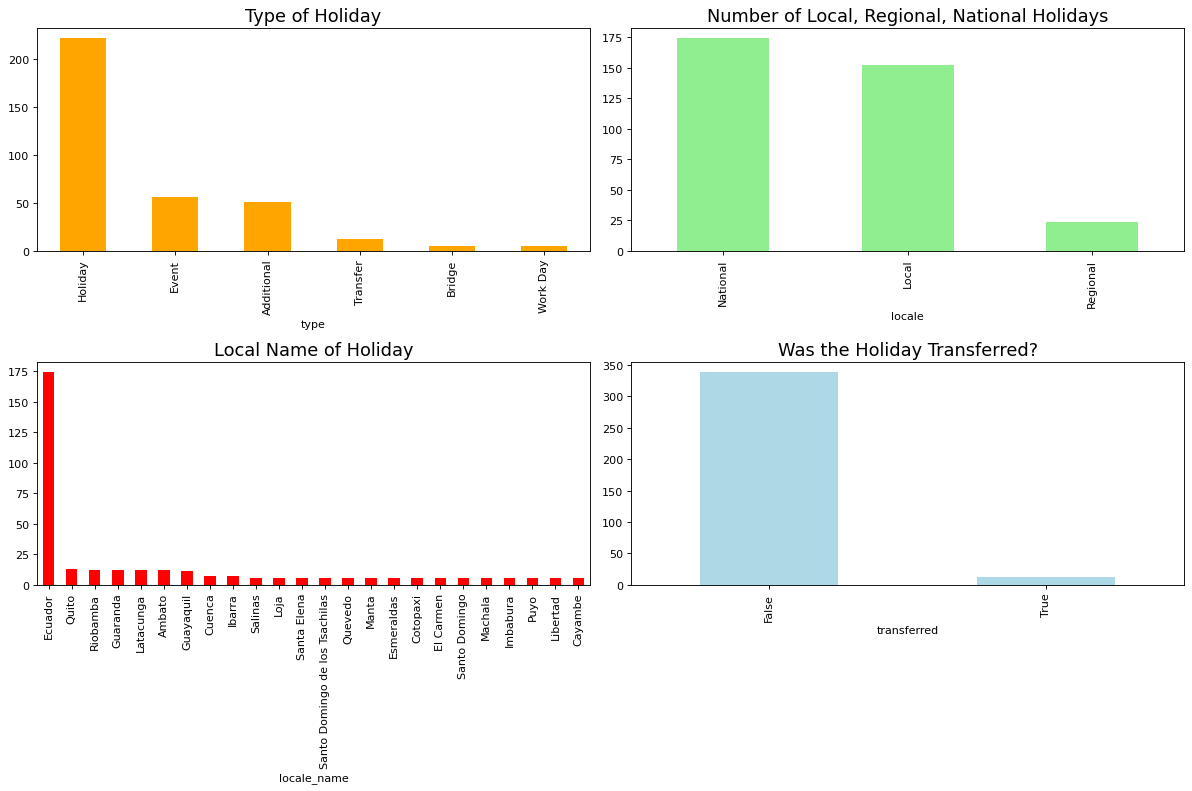

In [32]:
plt.figure(figsize=(15, 10), dpi=80)

plt.subplot(2, 2, 1)
holidays['type'].value_counts().plot.bar(color='orange')
plt.title('Type of Holiday',fontsize=16)

plt.subplot(2, 2, 2)
holidays['locale'].value_counts().plot.bar(color='lightgreen')
plt.title('Number of Local, Regional, National Holidays',fontsize=16)

plt.subplot(2, 2, 3)
holidays['locale_name'].value_counts().plot.bar(color='red')
plt.title('Local Name of Holiday',fontsize=16)

plt.subplot(2, 2, 4)
holidays['transferred'].value_counts().plot.bar(color='lightblue')
plt.title('Was the Holiday Transferred?',fontsize=16)

plt.tight_layout()
plt.show()

In [41]:
# Define a function to process holiday descriptions
def process_holiday(s):
    # Check if "futbol" is in the description; if so, return "futbol",this will help to aggregrate excess football related holidays
    if "futbol" in s:
        return "futbol"
    
    # Create a list of words to remove based on cities and states
    to_remove = list(set(stores['city'].str.lower()) | set(stores['state'].str.lower()))
    
    # Iterate through the list of words and remove them from the description
    for w in to_remove:
        s = s.replace(w, "")
    return s

# Clean and process the 'description' column in the holidays DataFram
holidays['description'] = holidays.apply(lambda x: x['description'].lower().replace(x['locale_name'].lower(), ""), axis=1).apply(process_holiday).replace(r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True).replace(r"\s+|-", " ", regex=True).str.strip()

# Remove transferred holidays from the DataFrame
holidays = holidays[holidays['transferred'].eq(False)]

# Extract and process work days
work_days = holidays[holidays['type'].eq("Work Day")]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}).reset_index(drop=True)

# Convert the 'work_day' column to binary values (1 for work days, 0 for others)
work_days['work_day'] = work_days['work_day'].notna().astype(int)


# Remove work days from the main holidays DataFrame
holidays = holidays[holidays['type']!="Work Day"].reset_index(drop=True)

In [45]:
holidays.head()
work_days.head()
holidays.describe()


,date,type,locale,locale_name,description,transferred
count,333,333,333,333,333,333
unique,296,5,3,24,17,1
top,2014-06-25,Holiday,National,Ecuador,fundacion,False
freq,4,209,161,161,76,333


Diffrentiate Holidays by
^Local
^National
^Regional

### Local holidays

In [46]:
# Filter local holidays at the city level
local_holidays = holidays[holidays['locale'].eq("Local")]
# Select relevant columns, rename 'locale_name' to 'local name', and reset the index
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "city"}).reset_index(drop=True)
# rename Ecuador to Quito.
local_holidays['city'] = local_holidays['city'].astype('category')
local_holidays['city'] = local_holidays['city'].cat.rename_categories({'Ecuador': 'Quito'})
# Remove duplicated rows
local_holidays = local_holidays[~local_holidays.duplicated()]
# Create dummy variables for 'description' and prefix them with "loc"
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc",dtype=int)
local_holidays.head()

,date,city,loc_cantonizacion,loc_fundacion,loc_independencia
0,2012-03-02,Manta,0,1,0
1,2012-04-12,Cuenca,0,1,0
2,2012-04-14,Libertad,1,0,0
3,2012-04-21,Riobamba,1,0,0
4,2012-05-12,Puyo,1,0,0


### Regional Holidays

In [49]:
# Filter local holidays at the city level
local_holidays = holidays[holidays['locale'].eq("Local")]
# Select relevant columns, rename 'locale_name' to 'local name', and reset the index
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "city"}).reset_index(drop=True)
# rename Ecuador to Quito.
local_holidays['city'] = local_holidays['city'].astype('category')
local_holidays['city'] = local_holidays['city'].cat.rename_categories({'Ecuador': 'Quito'})
# Remove duplicated rows
local_holidays = local_holidays[~local_holidays.duplicated()]
# Create dummy variables for 'description' and prefix them with "loc"
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc",dtype=int)
local_holidays.head()

,date,city,loc_cantonizacion,loc_fundacion,loc_independencia
0,2012-03-02,Manta,0,1,0
1,2012-04-12,Cuenca,0,1,0
2,2012-04-14,Libertad,1,0,0
3,2012-04-21,Riobamba,1,0,0
4,2012-05-12,Puyo,1,0,0


### National 

In [50]:
# Filter national holidays
national_holidays = holidays[holidays['locale'].eq("National")]

# Select relevant columns and reset the index
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)

# Remove duplicated rows
national_holidays = national_holidays[~national_holidays.duplicated()]

# Create dummy variables for 'description' and prefix them with "nat"
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# Group national holidays that fall on the same date and sum the binary values
national_holidays = national_holidays.groupby("date").sum().reset_index()

national_holidays

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito independencia,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2017-12-22,0,0,0,0,0,0,0,0,0,1,0,0,0,0
151,2017-12-23,0,0,0,0,0,0,0,0,0,1,0,0,0,0
152,2017-12-24,0,0,0,0,0,0,0,0,0,1,0,0,0,0
153,2017-12-25,0,0,0,0,0,0,0,0,0,1,0,0,0,0
